In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.plot
from osgeo import gdal
from rasterio import plot, mask, Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.windows import Window
import matplotlib.pyplot as plt
import rasterstats
import rioxarray
from shapely.geometry import box
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# %matplotlib widget
# %matplotlib inline

In [3]:
res_vrt_path = ["/home/jovyan/nz-landslides/1-raw-data/dem/2016_combined_res.vrt",
                "/home/jovyan/nz-landslides/1-raw-data/dem/2017_combined_res.vrt",
                "/home/jovyan/nz-landslides/1-raw-data/dem/2018_combined_res.vrt"]

# window = Window(col_off=100, row_off=100, width=11000, height=11000)

In [4]:
vrt16_fn = res_vrt_path[0]
# with rio.open(vrt16_fn, 'r+', IGNORE_COG_LAYOUT_BREAK='yes') as src:
#     src.nodata = 0.0
    
vrt16_src = rio.open(vrt16_fn)
vrt16_r = vrt16_src.read(1, masked=True)
# vrt16_r = vrt16_src.read(1, masked=True, window=window)

In [5]:
list(vrt16_src.transform)

[1.0, 0.0, 725859.0, 0.0, -1.0, 5324153.0, 0.0, 0.0, 1.0]

In [6]:
vrt17_fn = res_vrt_path[1]
# with rio.open(vrt17_fn, 'r+', IGNORE_COG_LAYOUT_BREAK='yes') as src:
#     src.nodata = 0.0
    
vrt17_src = rio.open(vrt17_fn)
vrt17_r = vrt17_src.read(1, masked=True)
# vrt17_r = vrt17_src.read(1, masked=True, window=window)

In [7]:
vrt18_fn = res_vrt_path[2]
# with rio.open(vrt18_fn, 'r+', IGNORE_COG_LAYOUT_BREAK='yes') as src:
#     src.nodata = 0.0
    
vrt18_src = rio.open(vrt18_fn)
vrt18_r = vrt18_src.read(1, masked=True)
# vrt18_r = vrt18_src.read(1, masked=True, window=window)

In [8]:
hs18_fn = "/home/jovyan/nz-landslides/1-raw-data/dem/2018_hs.vrt"
hs18_src = rio.open(hs18_fn)
hs18_r = hs18_src.read(1, masked=True)
hs18_r_extent = rio.plot.plotting_extent(hs18_src)

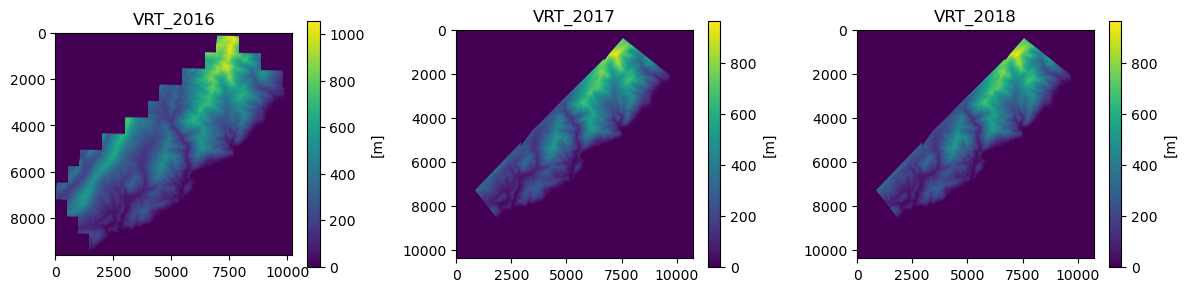

In [9]:
f, ax = plt.subplots(1,3, figsize=(12,3))
im = ax[0].imshow(vrt16_r)
ax[0].set_title('VRT_2016')
f.colorbar(im, ax=ax[0], label='[m]')
im = ax[1].imshow(vrt17_r)
ax[1].set_title('VRT_2017')
f.colorbar(im, ax=ax[1], label='[m]')
im = ax[2].imshow(vrt18_r)
ax[2].set_title('VRT_2018')
f.colorbar(im, ax=ax[2], label='[m]')
plt.tight_layout()

In [10]:
vrts = [vrt16_src, vrt17_src, vrt18_src]
lbls = ['2016', '2017', '2018']

for vrt, year in zip(vrts, lbls):
    print(year+':')
    print(vrt.profile)
    print()

2016:
{'driver': 'VRT', 'dtype': 'float32', 'nodata': None, 'width': 10221, 'height': 9598, 'count': 1, 'crs': CRS.from_epsg(32759), 'transform': Affine(1.0, 0.0, 725859.0,
       0.0, -1.0, 5324153.0), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}

2017:
{'driver': 'VRT', 'dtype': 'float32', 'nodata': None, 'width': 10752, 'height': 10367, 'count': 1, 'crs': CRS.from_epsg(32759), 'transform': Affine(1.0, 0.0, 726056.0,
       0.0, -1.0, 5323696.0), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}

2018:
{'driver': 'VRT', 'dtype': 'float32', 'nodata': None, 'width': 10752, 'height': 10367, 'count': 1, 'crs': CRS.from_epsg(32759), 'transform': Affine(1.0, 0.0, 726056.0,
       0.0, -1.0, 5323696.0), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}



In [11]:
proj_crs = vrt16_src.crs
proj_crs

CRS.from_epsg(32759)

In [12]:
inventory_fn = "/home/jovyan/nz-landslides/1-raw-data/polygon/landslides_inventory.gpkg"
filt_area    = "/home/jovyan/nz-landslides/1-raw-data/polygon/filtered_area.gpkg"

In [13]:
inventory_gpd = gpd.read_file(inventory_fn)
inventory_gpd.head()

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,geometry
0,1,1,6294.572688,971012.709717,971012.709717,None,None,"MULTIPOLYGON (((224168.801 5319214.443, 224176..."
1,2,0,534.474179,6510.391251,6510.391251,None,None,"MULTIPOLYGON (((224135.776 5318458.596, 224137..."
2,3,0,1600.066686,46399.058635,46399.058635,None,None,"MULTIPOLYGON (((223868.599 5318137.775, 223855..."
3,4,0,1645.958267,34457.252781,34457.252781,None,None,"MULTIPOLYGON (((224014.114 5317351.976, 224004..."
4,5,0,316.753483,4571.300600,4571.300600,None,None,"MULTIPOLYGON (((224074.165 5317697.594, 224088..."


In [14]:
filt_area_gpd = gpd.read_file(filt_area)
filt_area_gpd

,Id,geometry
0,0,"MULTIPOLYGON (((404866.590 724432.090, 404697...."


In [15]:
filt_area_gpd_proj = filt_area_gpd.to_crs(proj_crs)
filt_area_gpd_proj

,Id,geometry
0,0,"MULTIPOLYGON (((736106.196 5321302.405, 735931..."


In [16]:
inventory_gpd.crs

<Projected CRS: EPSG:32760>
Name: WGS 84 / UTM zone 60S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 174°E and 180°E, southern hemisphere between 80°S and equator, onshore and offshore. New Zealand.
- bounds: (174.0, -80.0, 180.0, 0.0)
Coordinate Operation:
- name: UTM zone 60S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
inventory_gpd_proj = inventory_gpd.to_crs(proj_crs)
inventory_gpd_proj

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,geometry
0,1,1,6294.572688,971012.709717,971012.709717,None,None,"MULTIPOLYGON (((719299.877 5321205.744, 719307..."
1,2,0,534.474179,6510.391251,6510.391251,None,None,"MULTIPOLYGON (((719213.776 5320454.354, 719214..."
2,3,0,1600.066686,46399.058635,46399.058635,None,None,"MULTIPOLYGON (((718924.785 5320153.235, 718916..."
3,4,0,1645.958267,34457.252781,34457.252781,None,None,"MULTIPOLYGON (((719014.603 5319359.419, 719006..."
4,5,0,316.753483,4571.300600,4571.300600,None,None,"MULTIPOLYGON (((719098.802 5319699.835, 719111..."
...,...,...,...,...,...,...,...,...
14228,14230,1,719.732270,24666.229609,24666.229609,None,None,"MULTIPOLYGON (((731718.510 5350803.831, 731722..."
14229,14231,0,787.175176,24079.652938,24079.652938,None,None,"MULTIPOLYGON (((687460.968 5294153.197, 687471..."
14230,14232,1,1009.043796,43493.688376,43493.688376,None,None,"MULTIPOLYGON (((687526.696 5294234.803, 687525..."
14231,14233,0,1046.510759,25285.918579,25285.918579,None,None,"MULTIPOLYGON (((727594.843 5347443.097, 727587..."


In [18]:
inventory_gpd_proj.crs

<Projected CRS: EPSG:32759>
Name: WGS 84 / UTM zone 59S
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 59S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
vrt16_extent = rio.plot.plotting_extent(vrt16_src)
vrt17_extent = rio.plot.plotting_extent(vrt17_src)
vrt18_extent = rio.plot.plotting_extent(vrt18_src)

In [20]:
xmin, ymin, xmax, ymax = filt_area_gpd_proj.total_bounds

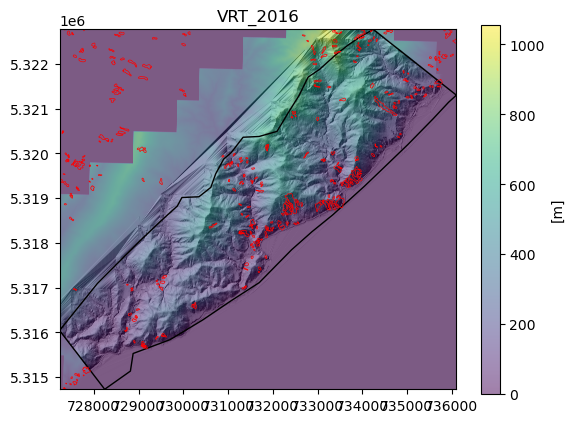

In [21]:
f, ax = plt.subplots()
ax.imshow(hs18_r, extent=hs18_r_extent, cmap='gray')
im = ax.imshow(vrt16_r, extent=vrt16_extent, alpha=0.5)
filt_area_gpd_proj.plot(ax=ax, facecolor='none', edgecolor='k')
inventory_gpd_proj.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=0.5)
ax.set_title('VRT_2016')
f.colorbar(im, ax=ax, label='[m]')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

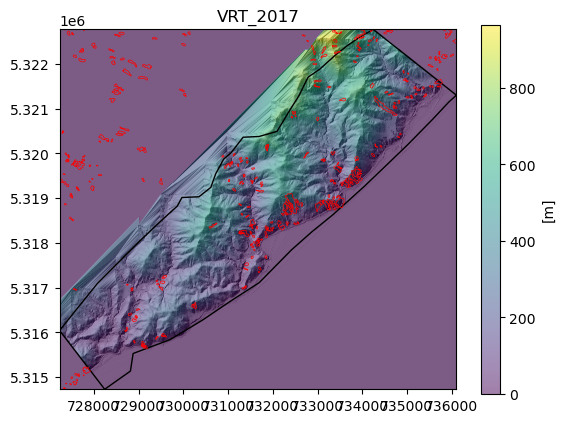

In [22]:
f, ax = plt.subplots()
ax.imshow(hs18_r, extent=hs18_r_extent, cmap='gray')
im = ax.imshow(vrt17_r, extent=vrt17_extent, alpha=0.5)
filt_area_gpd_proj.plot(ax=ax, facecolor='none', edgecolor='k')
inventory_gpd_proj.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=0.5)
ax.set_title('VRT_2017')
f.colorbar(im, ax=ax, label='[m]')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

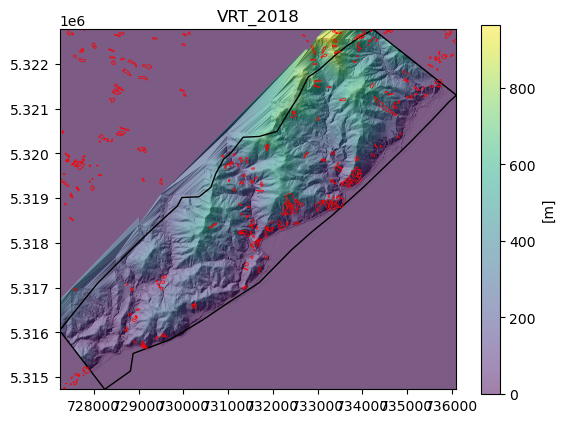

In [23]:
f, ax = plt.subplots()
ax.imshow(hs18_r, extent=hs18_r_extent, cmap='gray')
im = ax.imshow(vrt18_r, extent=vrt18_extent, alpha=0.5)
filt_area_gpd_proj.plot(ax=ax, facecolor='none', edgecolor='k')
inventory_gpd_proj.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=0.5)
ax.set_title('VRT_2018')
f.colorbar(im, ax=ax, label='[m]')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

In [24]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
fa_hull = filt_area_gpd_proj.unary_union.convex_hull.buffer(-20)
fa_geom = gpd.GeoDataFrame(geometry=[fa_hull], crs=proj_crs)
fa_geom

,geometry
0,"POLYGON ((728244.353 5314751.721, 727256.914 5..."


In [25]:
vrt16_fa_ma, vrt16_fa_transform = rio.mask.mask(vrt16_src, fa_geom.geometry, **rio_mask_kwargs)
vrt16_fa_ma_extent = rio.plot.plotting_extent(vrt16_fa_ma, vrt16_fa_transform)

In [26]:
vrt16_fa_transform

Affine(1.0, 0.0, 727256.0,
       0.0, -1.0, 5322749.0)

In [27]:
vrt17_fa_ma, vrt17_fa_transform = rio.mask.mask(vrt17_src, fa_geom.geometry, **rio_mask_kwargs)
vrt17_fa_ma_extent = rio.plot.plotting_extent(vrt17_fa_ma, vrt17_fa_transform)

In [28]:
vrt17_fa_transform

Affine(1.0, 0.0, 727256.0,
       0.0, -1.0, 5322749.0)

In [29]:
vrt18_fa_ma, vrt18_fa_transform = rio.mask.mask(vrt18_src, fa_geom.geometry, **rio_mask_kwargs)
vrt18_fa_ma_extent = rio.plot.plotting_extent(vrt18_fa_ma, vrt18_fa_transform)

In [30]:
hs_fa_ma, hs_fa_transform = rio.mask.mask(hs18_src, fa_geom.geometry, **rio_mask_kwargs)
hs_fa_ma_extent = rio.plot.plotting_extent(hs_fa_ma, hs_fa_transform)

In [31]:
inventory_gpd_clipped = gpd.clip(inventory_gpd_proj, fa_geom)
inventory_gpd_clipped.head()

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,geometry
13410,13412,0,147.985920,1348.158784,1348.158784,None,None,"POLYGON ((728916.504 5315756.778, 728915.663 5..."
13471,13473,0,80.741391,407.936149,407.936149,None,None,"POLYGON ((728705.038 5316015.623, 728704.600 5..."
13463,13465,0,158.667128,1675.133073,1675.133073,None,None,"POLYGON ((729182.519 5315635.024, 729181.302 5..."
13464,13466,0,177.412938,1572.323108,1572.323108,None,None,"POLYGON ((729136.188 5315641.165, 729134.479 5..."
13465,13467,0,134.624908,727.482580,727.482580,None,None,"POLYGON ((729119.932 5315652.249, 729118.900 5..."


In [32]:
vrt16_fa_ma_extent

(727256.0, 736077.0, 5314751.0, 5322749.0)

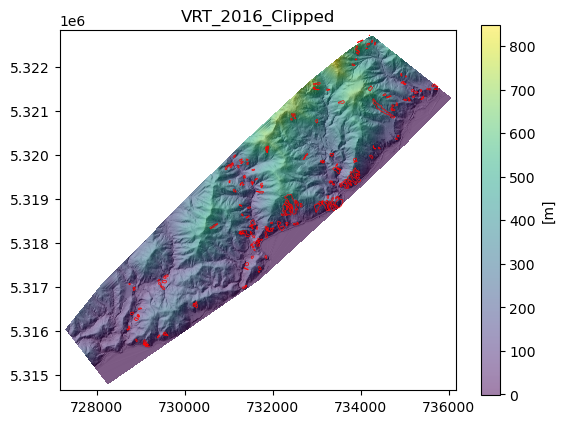

In [33]:
xmin, xmax, ymin, ymax = vrt16_fa_ma_extent

f, ax = plt.subplots()
ax.imshow(hs_fa_ma, extent=hs_fa_ma_extent, cmap='gray')
im = ax.imshow(vrt16_fa_ma, extent=vrt16_fa_ma_extent, alpha=0.5, cmap='viridis')
inventory_gpd_clipped.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=0.5)
ax.set_title('VRT_2016_Clipped')
f.colorbar(im, ax=ax, label='[m]')
plt.xlim(xmin-100, xmax+100)
plt.ylim(ymin-100, ymax+100)
plt.show()

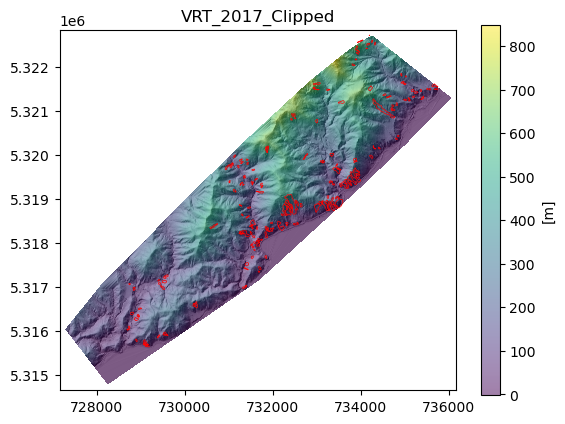

In [34]:
xmin, xmax, ymin, ymax = vrt17_fa_ma_extent

f, ax = plt.subplots()
ax.imshow(hs_fa_ma, extent=hs_fa_ma_extent, cmap='gray')
im = ax.imshow(vrt17_fa_ma, extent=vrt17_fa_ma_extent, alpha=0.5)
inventory_gpd_clipped.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=0.5)
ax.set_title('VRT_2017_Clipped')
f.colorbar(im, ax=ax, label='[m]')
plt.xlim(xmin-100, xmax+100)
plt.ylim(ymin-100, ymax+100)
plt.show()

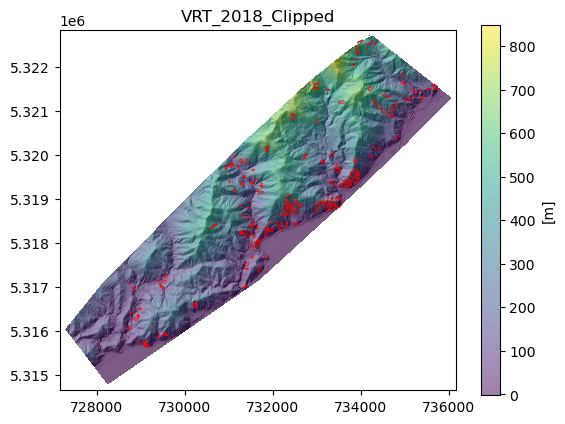

In [35]:
xmin, xmax, ymin, ymax = vrt18_fa_ma_extent

f, ax = plt.subplots()
ax.imshow(hs_fa_ma, extent=hs_fa_ma_extent, cmap='gray')
im = ax.imshow(vrt18_fa_ma, extent=vrt18_fa_ma_extent, alpha=0.5)
inventory_gpd_clipped.plot(ax=ax, facecolor='none', edgecolor='r', linewidth=0.5)
ax.set_title('VRT_2018_Clipped')
f.colorbar(im, ax=ax, label='[m]')
plt.xlim(xmin-100, xmax+100)
plt.ylim(ymin-100, ymax+100)
plt.show()

In [36]:
def create_tif(masked_array, transform, output_path, crs='EPSG:4326', nodata=0.0):
    # Convert the masked array to a filled array with the specified nodata value
    filled_array = np.where(masked_array.mask, nodata, masked_array)

    # Define metadata
    profile = {
        'driver': 'GTiff',
        'height': filled_array.shape[0],
        'width': filled_array.shape[1],
        'count': 1,  # Number of bands
        'dtype': 'float32',  # Data type of the array
        'transform': transform,  # Affine transformation
        'crs': crs,  # CRS (Coordinate Reference System)
        'nodata': nodata  # Nodata value
    }

    # Create the output raster file
    with rasterio.open(output_path, 'w', **profile) as dst:
        # Write the filled array to the raster file
        dst.write(filled_array.astype('float32'), 1)

In [37]:
def create_vrt_from_tif(input_tif, output_vrt):
    # Open the input TIFF file
    tif_ds = gdal.Open(input_tif)

    # Create the VRT dataset
    vrt_ds = gdal.BuildVRT(output_vrt, tif_ds)

    # Close the datasets
    tif_ds = None
    vrt_ds = None

In [38]:
mas = [vrt16_fa_ma, vrt17_fa_ma, vrt18_fa_ma, hs_fa_ma]

In [39]:
processed_tif_path = ["/home/jovyan/nz-landslides_local/2-processed data/dem/ma_dem_2016.tif",
                      "/home/jovyan/nz-landslides_local/2-processed data/dem/ma_dem_2017.tif",
                     "/home/jovyan/nz-landslides_local/2-processed data/dem/ma_dem_2018.tif",
                     "/home/jovyan/nz-landslides_local/2-processed data/dem/ma_hs.tif"]

In [40]:
processed_vrt_path = ["/home/jovyan/nz-landslides/2-processed data/dem/ma_dem_2016.vrt",
                      "/home/jovyan/nz-landslides/2-processed data/dem/ma_dem_2017.vrt",
                     "/home/jovyan/nz-landslides/2-processed data/dem/ma_dem_2018.vrt",
                     "/home/jovyan/nz-landslides/2-processed data/dem/ma_hs.vrt"]

In [41]:
proj_crs

CRS.from_epsg(32759)

In [42]:
for ma, tif, vrt in zip(mas, processed_tif_path, processed_vrt_path):
    create_tif(ma, vrt17_fa_transform, tif, crs='EPSG:32759', nodata=0.0)
    create_vrt_from_tif(tif, vrt)

/srv/conda/envs/notebook/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [43]:
inventory_gpd_clipped.to_file("/home/jovyan/nz-landslides/2-processed data/polygon/clipped_inventory.gpkg", driver='GPKG')